In [2]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
import tqdm

In [3]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

c:\Users\Allen\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Allen\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

In [7]:
# helper function for un-normalizing an image
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [10]:
# load in content and style image, replace the following paths
# as the image path you want to use for content and style

content_path = 'a person sitting on the ground reading a book.jpg'
style_path = 'an orange tree in a field with a blue sky in the background.jpg'


content = load_image(content_path)
style = load_image(style_path, shape=content.shape[-2:])


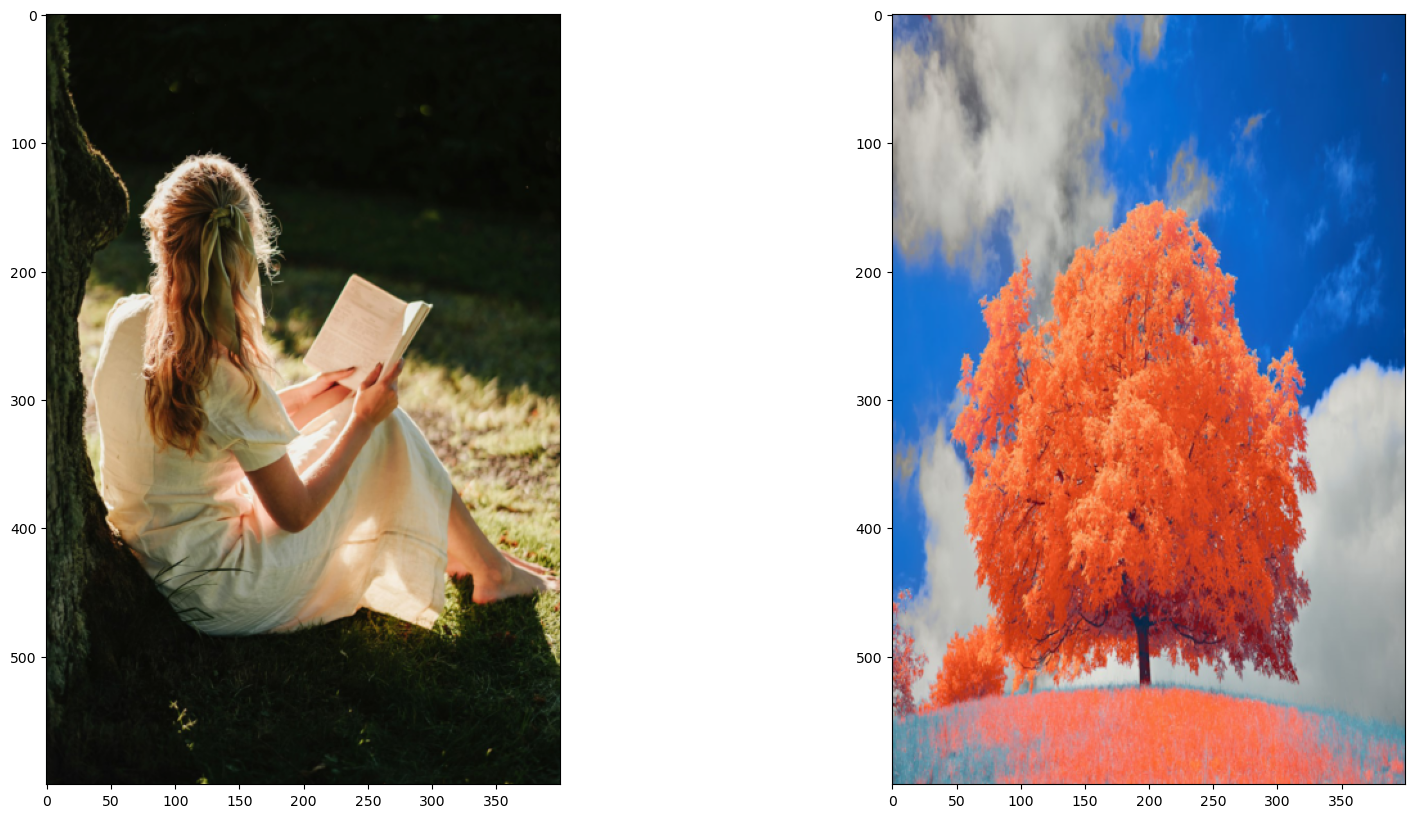

In [11]:
# Showing the content and style images
content = content.to(device)
style = style.to(device)

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [12]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [13]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '12': 'conv3_2',
                  '21': 'conv4_2', # content representation
                  '28': 'conv5_1',
                  }


    ## -- do not need to change the code below this line -- ##
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [14]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """

    ## get the batch_size, depth, height, and width of the Tensor
    ## reshape it, so we're multiplying the features for each channel
    ## calculate the gram matrix
    batch_size, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)

    gram = torch.mm(tensor, tensor.t())

    return gram

In [15]:
# Get the content feature and style feature through VGG
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Gram matrix for the style features
style_gms = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Cloning target image
target = content.clone().requires_grad_(True).to(device)

# Blank target image to see the different effect on the initialization
target_blank = torch.empty(target.shape, requires_grad=True, device="cuda")

In [16]:
def stylize(content_path, style_path, out_path, target_init = "clone", out_format = "image-only",
            lr = 0.03, show_every = 500, steps = 2000, style_layer_weight_exp = 1, content_weight_blend = 1,
            content_weight = 7.5, style_weight = 1e2, tv_weight = 2e2):
    """
    Transfer the style of the style image to the content image with pre-trained vgg-19 arch
    itect without final classifier layer, uses 'conv1_1, conv2_1, conv3_1, conv4_1, conv5_1'
    from the style image as the style layer , 'conv4_2' from the content image as the conte
    nt layer. The network uses Adam as the optimizer and optimizes the total loss of the ta
    rget image.

    During the training process, the network remains static and won't be trained on. The ta
    rget image will keep get updated with iterations within the network.

    Args:
        target_init (str): The initialization method for the target image. "clone" initiali
        zes a target image that is identical to the content image. "blank" initializes the
        target image as a blank image. "random" initializes the target image with random no
        ises.
        content_path (str): The directory path to the content image.
        style_path(str): The directory path to the style image.
        out_path(str): The directory path of the output image.
        out_format(str): The output format with two possible methods: "image-only" exports
        only the output, "comparison" exports the comparison between the content image, st
        yle image and the output image.
        lr: learning rate of the optimizer.
        show_every: The frequency to show the progress, loss and intermediate result.
        steps: The number of iterations.
        style_layer_weight_exp: The exponential decay or increase factor for the style lay
        ers, the higher the value, the more coarse the output would be, default is 1.
        content_weight_blend: A number within [0,1]. The factor that controls the details
        preserved in the content image, the higher the value, the finer details are preser
        ved.
        content_weight: The weight of the content loss.
        style_weight: The weight of the style loss.
        tv_weight: The weight of the total variation loss for denoising.
    Raises:
        ValueError:
            When the target_init receives an unexpected method.
            When the out_format receives an unexpected format
    """

    #see if cuda is available, if not, use cpu instead (Could be extremely slow)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #loading content and style images
    content = load_image(content_path).to(device)
    style = load_image(style_path, shape=content.shape[-2:]).to(device)
    print("=======================Image Loading Completed===========================")

    #define target
    if target_init == "clone":
        target = content.clone().requires_grad_(True).to(device)
        # maintain the weights constant as the target will be initialized as the content image
    elif target_init == "blank":
        target = torch.full(content.shape,fill_value = 0.5, requires_grad=True, device=device)
        # change the weights to be a more aggresive degree
    elif target_init == "random":
        target = torch.rand(content.shape, requires_grad=True, device=device)
    else:
        raise ValueError('Unexpected Initialization Method{}'.format(target_init))
    print("=======================Target Definition Completed, Mode: {}===========================".format(target_init))

    #optimizer
    lr = lr if target_init == "clone" else min(lr*10, 0.2)
    optimizer = optim.Adam([target], lr = lr)
    print("=======================Optimizer: Adam, Learning Rate:{}===========================".format(lr))

    #get the content and style features
    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)
    #style gram matrices
    style_gms = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    print("=======================Feature Extraction And Gram Matrix Calculation Completed===========================")

    #set the weights for each style layer
    style_layers = ['conv1_1','conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
    layer_weight = 1.0
    style_layers_weights = {}
    for style_layer in style_layers:
        style_layers_weights[style_layer] = layer_weight
        layer_weight *= style_layer_weight_exp

    #content weight blend
    content_layers_weights = {}
    content_layers_weights['conv3_2'] = content_weight_blend
    content_layers_weights['conv4_2'] = 1 - content_weight_blend


    for ii in tqdm.tqdm(range(1, steps + 1)):
        # use different weight value for different initialization methods
        if target_init == "blank" or target_init == "random":
            if ii <= steps * 0.2:
                content_weight = 1
                style_weight = 0.01
                tv_weight = 2
            else:
                content_weight = 10
                style_weight = 1e2
                tv_weight = 20
        # overview of initialization
        if ii == 1:
            if target_init == "clone":
                print("=======================Initial Setting===========================",
                      "\ncontent weight:{}".format(content_weight),
                      "\nstyleweight:{}".format(style_weight),
                      "\ntotal variation denoising weight:{}".format(tv_weight))
            else:
                print("=======================Initial Setting: Reconstructing Content First===========================",
                      "\ncontent weight:{}".format(content_weight),
                      "\nstyleweight:{}".format(style_weight),
                      "\ntotal variation denoising weight:{}".format(tv_weight))
        elif ii == steps * 0.2:
            if target_init == "random" or target_init == "blank":
                print("=======================Intermediate Setting: Constructing Style===========================",
                      "\ncontent weight:{}".format(content_weight),
                      "\nstyleweight:{}".format(style_weight),
                      "\ntotal variation denoising weight:{}".format(tv_weight))

        ############################ Loss calculation #########################################

        # extract target features
        target_features = get_features(target, vgg)
        # content loss
        content_loss = 0
        for layer in content_layers_weights:
            content_loss += content_layers_weights[layer] * torch.mean((target_features[layer] - content_features[layer]) ** 2)
        # style loss
        style_loss = 0
        for layer in style_layers_weights:
            target_features_layer = target_features[layer]
            batch_size, d, h, w = target_features_layer.shape

            # gram matrix of target image
            target_gram = gram_matrix(target_features_layer)
            # gram matrix of style image
            style_gram = style_gms[layer]
            layer_style_loss = style_layers_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
            style_loss +=  layer_style_loss / (d * h * w)

        # total variation denoising
        batch_size = target.size()[0]
        h_x = target.size()[2]
        w_x = target.size()[3]
        count_h =  (target.size()[2]-1) * target.size()[3]
        count_w = target.size()[2] * (target.size()[3] - 1)
        h_tv = torch.abs(target[:,:,1:,:]-target[:,:,:h_x-1,:]).sum()
        w_tv = torch.abs(target[:,:,:,1:]-target[:,:,:,:w_x-1]).sum()

        tv_loss =  2 * (h_tv/count_h + w_tv/count_w) / batch_size
        total_loss = content_weight * content_loss + style_weight * style_loss + tv_weight * tv_loss

        # Update the target
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if ii % show_every == 0:
            print("Total loss:", total_loss.item(), "\nContent loss:", content_loss.item(),"\nStyle loss:", style_loss.item(), "\nTV loss:", tv_loss.item())
            print("Progress:{}%".format(round(float(ii/steps), 3) * 100))
            plt.imshow(im_convert(target))
            plt.show()

    # exporting final result
    if target_init == "clone":
    # reverse normalization
        target = target.detach().cpu().view(-1, h_x, w_x)
        target_out = target.new(*target.size())
        std = [0.229, 0.224, 0.225]
        mean = [0.485, 0.456, 0.406]

        target_out[0, :, :] = target[0, :, :] * std[0] + mean[0]
        target_out[1, :, :] = target[1, :, :] * std[1] + mean[1]
        target_out[2, :, :] = target[2, :, :] * std[2] + mean[2]
        target_out = target_out.clamp(0,1)
    else:
        target_out = target
    if out_format == "image-only":
        # export only the result of style transfer
        target_out = transforms.ToPILImage("RGB")(target_out)
        target_out.save(out_path)
    elif out_format == "comparison":
        # export the comparison of content, style and results of style transfer
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(22, 30))
        ax1 = plt.subplot(212)
        ax1.imshow(im_convert(target))
        ax1.axis('off')
        ax1.set_title('Output', size = 40)

        ax2 = plt.subplot(221)
        ax2.imshow(im_convert(content))
        ax2.axis('off')
        ax2.set_title('Content', size = 20)

        ax3 = plt.subplot(222)
        ax3.imshow(im_convert(style))
        ax3.axis('off')
        ax3.set_title('Style', size = 20)
        plt.subplots_adjust(bottom=0.1, right=0.8, top=1.15)
        fig.tight_layout(pad = 1)
        plt.savefig(out_path)
    else:
        raise ValueError('Unexpected Output Format{}'.format(out_format))

=======================Image Loading Completed===========================
=======================Target Definition Completed, Mode: clone===========================
=======================Optimizer: Adam, Learning Rate:0.03===========================
=======================Feature Extraction And Gram Matrix Calculation Completed===========================


  0%|          | 0/7000 [00:00<?, ?it/s]

=======================Initial Setting=========================== 
content weight:7.5 
styleweight:100.0 
total variation denoising weight:200.0


  7%|▋         | 499/7000 [01:03<13:40,  7.92it/s]

Total loss: 547.45166015625 
Content loss: 8.875826835632324 
Style loss: 2.781414747238159 
TV loss: 1.0137073993682861
Progress:7.1%


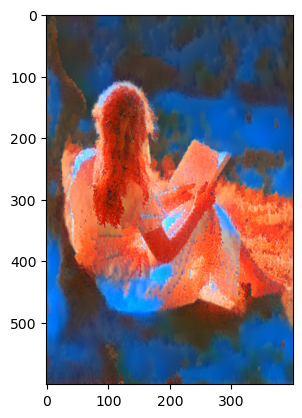

 14%|█▍        | 999/7000 [02:07<13:03,  7.66it/s]

Total loss: 362.11834716796875 
Content loss: 8.500544548034668 
Style loss: 1.2633577585220337 
TV loss: 0.8601424694061279
Progress:14.299999999999999%


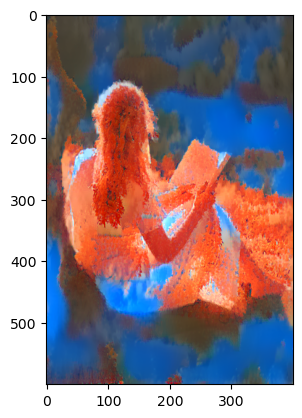

 21%|██▏       | 1499/7000 [03:13<11:57,  7.67it/s]

Total loss: 310.74774169921875 
Content loss: 8.318766593933105 
Style loss: 0.8506847023963928 
TV loss: 0.816442608833313
Progress:21.4%


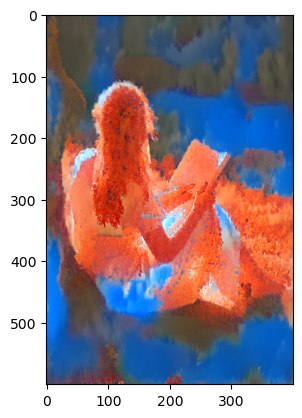

 29%|██▊       | 1999/7000 [04:19<11:16,  7.39it/s]

Total loss: 574.9946899414062 
Content loss: 9.269726753234863 
Style loss: 2.575721025466919 
TV loss: 1.2394981384277344
Progress:28.599999999999998%


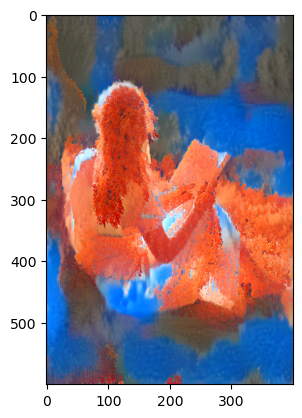

 36%|███▌      | 2499/7000 [05:26<10:23,  7.22it/s]

Total loss: 390.82879638671875 
Content loss: 8.362086296081543 
Style loss: 1.545894742012024 
TV loss: 0.8676183223724365
Progress:35.699999999999996%


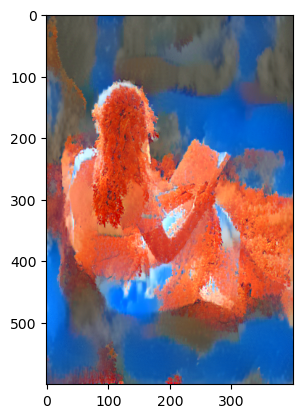

 43%|████▎     | 2999/7000 [06:33<08:54,  7.48it/s]

Total loss: 397.4010009765625 
Content loss: 8.186878204345703 
Style loss: 1.7388484477996826 
TV loss: 0.8105727434158325
Progress:42.9%


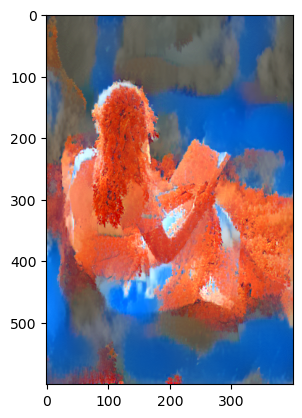

 50%|████▉     | 3499/7000 [07:40<07:47,  7.49it/s]

Total loss: 260.3436279296875 
Content loss: 8.003851890563965 
Style loss: 0.4632470905780792 
TV loss: 0.7699500918388367
Progress:50.0%


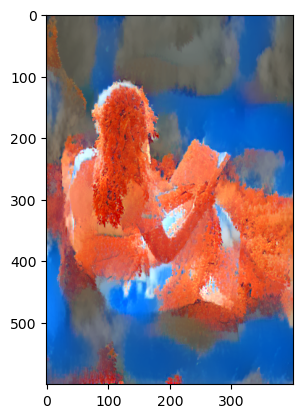

 57%|█████▋    | 3999/7000 [08:48<06:41,  7.48it/s]

Total loss: 263.63568115234375 
Content loss: 8.059645652770996 
Style loss: 0.45656636357307434 
TV loss: 0.7876586318016052
Progress:57.099999999999994%


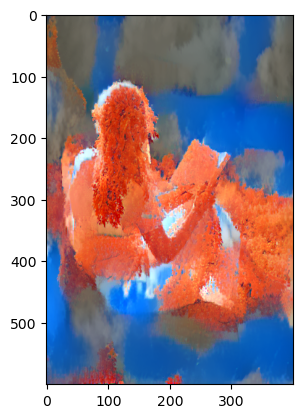

 64%|██████▍   | 4499/7000 [09:56<05:39,  7.38it/s]

Total loss: 253.15919494628906 
Content loss: 8.001910209655762 
Style loss: 0.4010870158672333 
TV loss: 0.7651808261871338
Progress:64.3%


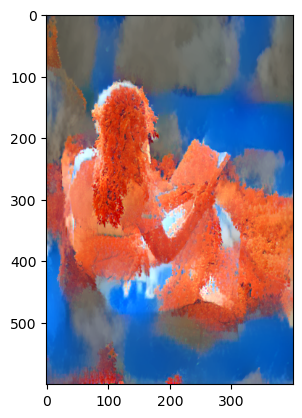

 71%|███████▏  | 4999/7000 [11:04<04:31,  7.36it/s]

Total loss: 373.8321838378906 
Content loss: 8.616132736206055 
Style loss: 1.1379899978637695 
TV loss: 0.9770609736442566
Progress:71.39999999999999%


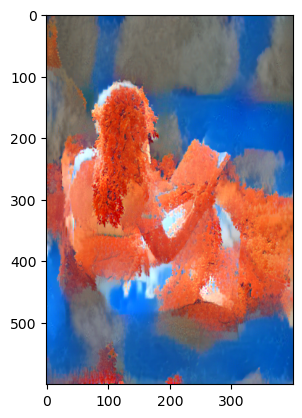

 79%|███████▊  | 5499/7000 [12:13<03:25,  7.29it/s]

Total loss: 338.13763427734375 
Content loss: 8.851444244384766 
Style loss: 0.6383028030395508 
TV loss: 1.0396075248718262
Progress:78.60000000000001%


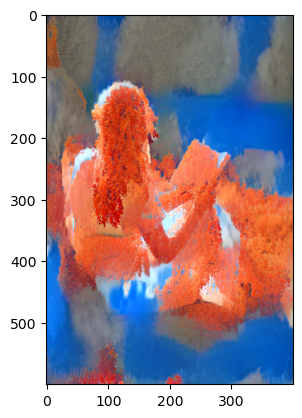

 86%|████████▌ | 5999/7000 [13:22<02:12,  7.55it/s]

Total loss: 252.9260711669922 
Content loss: 7.8764142990112305 
Style loss: 0.42486581206321716 
TV loss: 0.7568318843841553
Progress:85.7%


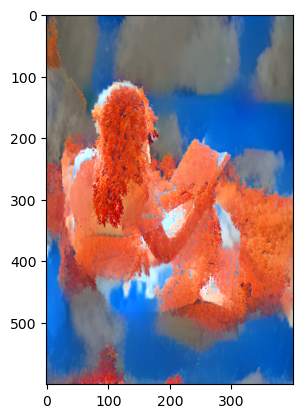

 93%|█████████▎| 6499/7000 [14:30<01:08,  7.31it/s]

Total loss: 303.3410339355469 
Content loss: 8.559843063354492 
Style loss: 0.4870351552963257 
TV loss: 0.9521934986114502
Progress:92.9%


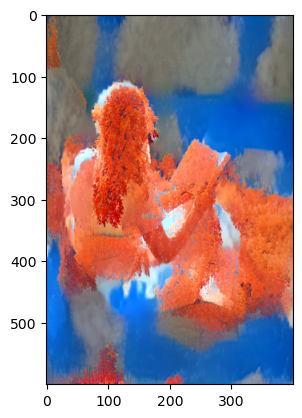

100%|█████████▉| 6999/7000 [15:40<00:00,  7.41it/s]

Total loss: 268.37847900390625 
Content loss: 8.20689868927002 
Style loss: 0.3739582896232605 
TV loss: 0.8471545577049255
Progress:100.0%


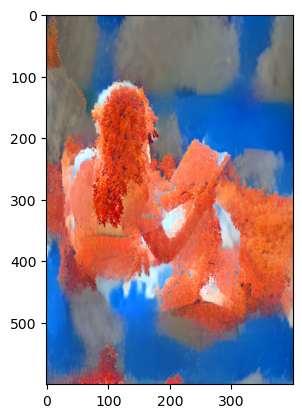

100%|██████████| 7000/7000 [15:41<00:00,  7.44it/s]


In [17]:
stylize(content_path = content_path, style_path = style_path, out_path = "result.png", target_init = "clone", out_format = "image-only", steps = 7000)